# Context

The goal of this **project** is to **forecast** the daily average temperature (**tavg**) with a small margin of error within a window of **at least 365 days**. This notebook focuses on generating inputs for the next phase: modeling.  

Given the project's objectives, **this notebook** is **divided into three phases**. The first phase involves **treating the features**, performing feature engineering, and selecting relevant features. Next, we will **explore potential time series modeling** techniques. Finally, in the third phase, we will **investigate ML methods** to model the **residuals** from the time series forecasting phase, using the remaining variables, as analyzed in *eda_target.ipynb*.

# Data Source
The data used in this notebook was generated from the "eda_target.ipynb" notebook.

- **Data:** 10/03/2025
- **Localização:** ../data/wrangle/weather_forecast_target.parquet

# Set up

In [162]:
## Base
import numpy as np
import pandas as pd
import os

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[0].as_posix())

from src.ts_utils import *
from config import *

In [163]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

In [164]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

In [165]:
weather_df = pd.read_parquet('../data/wrangle/weather_forecast_target.parquet')
display(weather_df.tail())
weather_df.info()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal,tavg_seasonal,tavg_seasonal_resid,resids
2483,2023-12-27,277.2,0.0,0.0,4.3,1016.0,7.3,Northeast,272.828849,4.371151,2.403314
2484,2023-12-28,278.0,5.8,0.0,4.8,1009.7,3.4,North,272.727608,5.272392,1.406972
2485,2023-12-29,277.9,6.1,0.0,4.8,1009.9,6.7,North,272.629968,5.270032,1.735632
2486,2023-12-30,274.1,0.0,0.0,3.6,1011.8,5.6,Southwest,272.535960,1.564040,-2.300603
2487,2023-12-31,274.4,0.5,0.0,4.9,1014.5,3.3,West,272.445611,1.954389,1.545666


<class 'pandas.core.frame.DataFrame'>
Index: 2488 entries, 0 to 2487
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 2488 non-null   datetime64[ns]
 1   tavg                 2488 non-null   float64       
 2   prcp                 2488 non-null   float64       
 3   snow                 2488 non-null   float64       
 4   wspd                 2488 non-null   float64       
 5   pres                 2488 non-null   float64       
 6   tamp                 2488 non-null   float64       
 7   wcardinal            2485 non-null   category      
 8   tavg_seasonal        2488 non-null   float64       
 9   tavg_seasonal_resid  2488 non-null   float64       
 10  resids               2488 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(9)
memory usage: 216.6 KB


# Features
In this section, we will remove the trend and seasonality from the series below, creating the residual features (*resid features*). Additionally, we will generate new features based on the existing ones and identify and select those that contribute the most to forecasting the *resids* variable.

In [166]:
'prcp', 'snow', 'wspd', 'pres', 'tamp', 'wcardinal'

('prcp', 'snow', 'wspd', 'pres', 'tamp', 'wcardinal')

## Feature Engineering  
Our features, as they are, are not yet suitable for forecasting/predicting the residuals of the target forecast. They may still contain trends, seasonality, and autocorrelation, which could mask potentially useful predictors.  

Therefore, as a first step, we will remove the trend, seasonality, and autocorrelation from the features, creating **residual features**. From these, we will generate new potential predictors, such as **lagged residual features** and **moving average residual features**.

### Resid Features
For each feature, we need to check its stationarity, along with the ACF and PACF plots, to determine the parameters of the ARIMA model. From this, we can create the residual feature for that particular feature.

#### prcp
Precipitation volume in mm

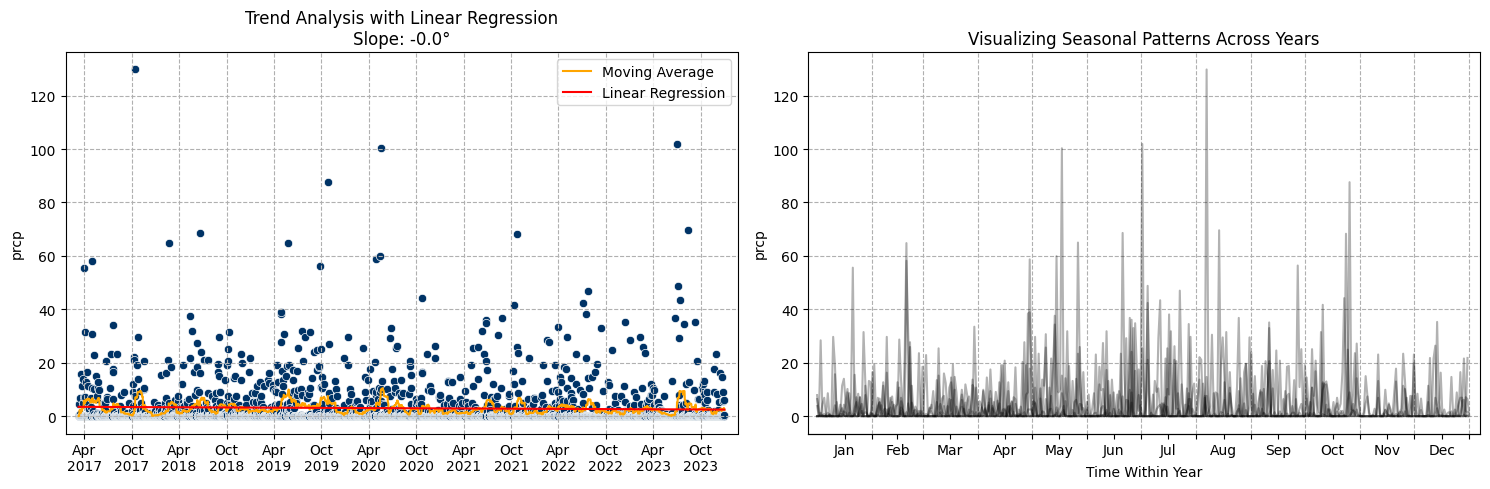

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/pedro/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


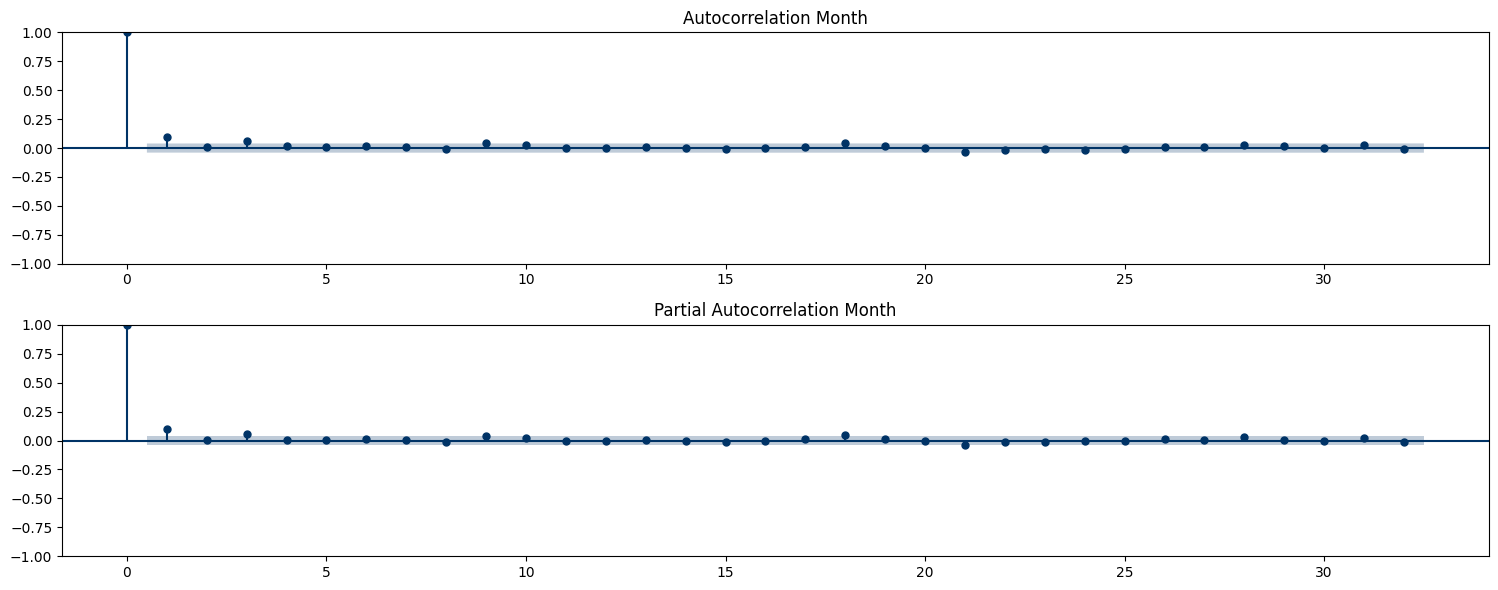

In [167]:
ts_quick_insights(weather_df['prcp'], weather_df['time'])   
stationary_tests(weather_df['prcp'])
plot_acf_pacf(weather_df['prcp'])

The variable prcp does not exhibit trend or seasonality and is stationary. Upon analyzing the ACF and PACF plots, one might question whether there is significant autocorrelation at lag one. However, from the plots, we observe that the autocorrelation is minimal, leading us to conclude that the residual feature for this variable is the variable itself.

In [168]:
weather_df['r_prcp'] = weather_df['prcp'] 

#### snow
As seen below, the variable snow is sparse (with over 90% of missing values), and therefore, this time series analysis does not align with its nature.

In [169]:
weather_df['snow'].value_counts(normalize=True)*100

snow
0.0      90.635048
25.0      3.456592
51.0      1.889068
76.0      1.045016
102.0     0.723473
152.0     0.281350
127.0     0.281350
279.0     0.241158
254.0     0.200965
229.0     0.200965
356.0     0.160772
178.0     0.160772
203.0     0.160772
305.0     0.120579
330.0     0.120579
660.0     0.080386
533.0     0.080386
381.0     0.040193
483.0     0.040193
457.0     0.040193
406.0     0.040193
Name: proportion, dtype: float64

In [170]:
weather_df['r_snow'] = weather_df['snow']

#### wspd
Average wind speed

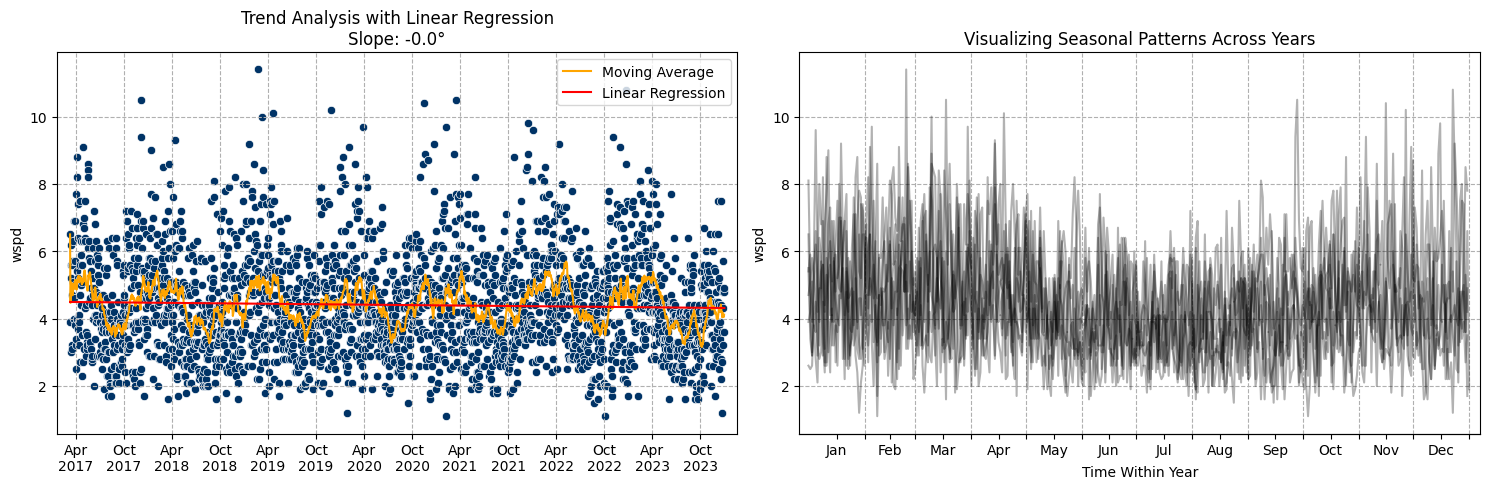

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/pedro/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


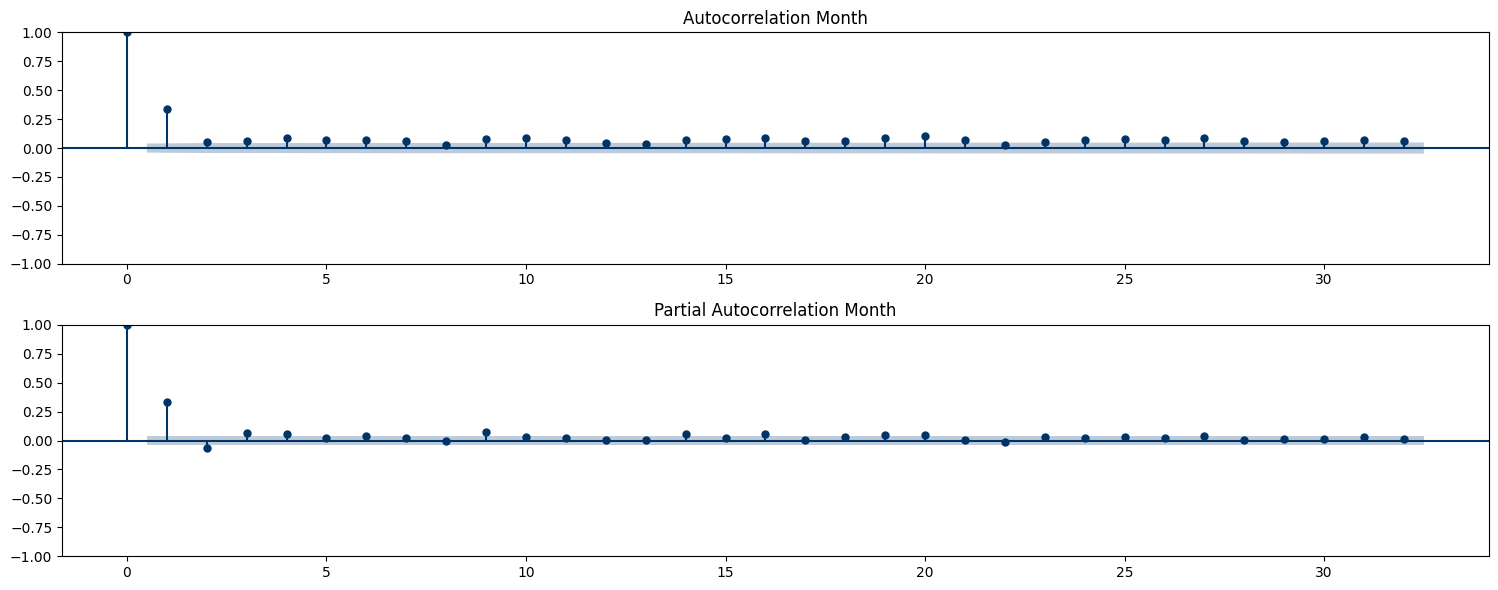

In [171]:
ts_quick_insights(weather_df['wspd'], weather_df['time'])   
stationary_tests(weather_df['wspd'])
plot_acf_pacf(weather_df['wspd'])

Based on the information above, we conclude that the series is stationary and can be modeled using an ARIMA(1,0,1) model.

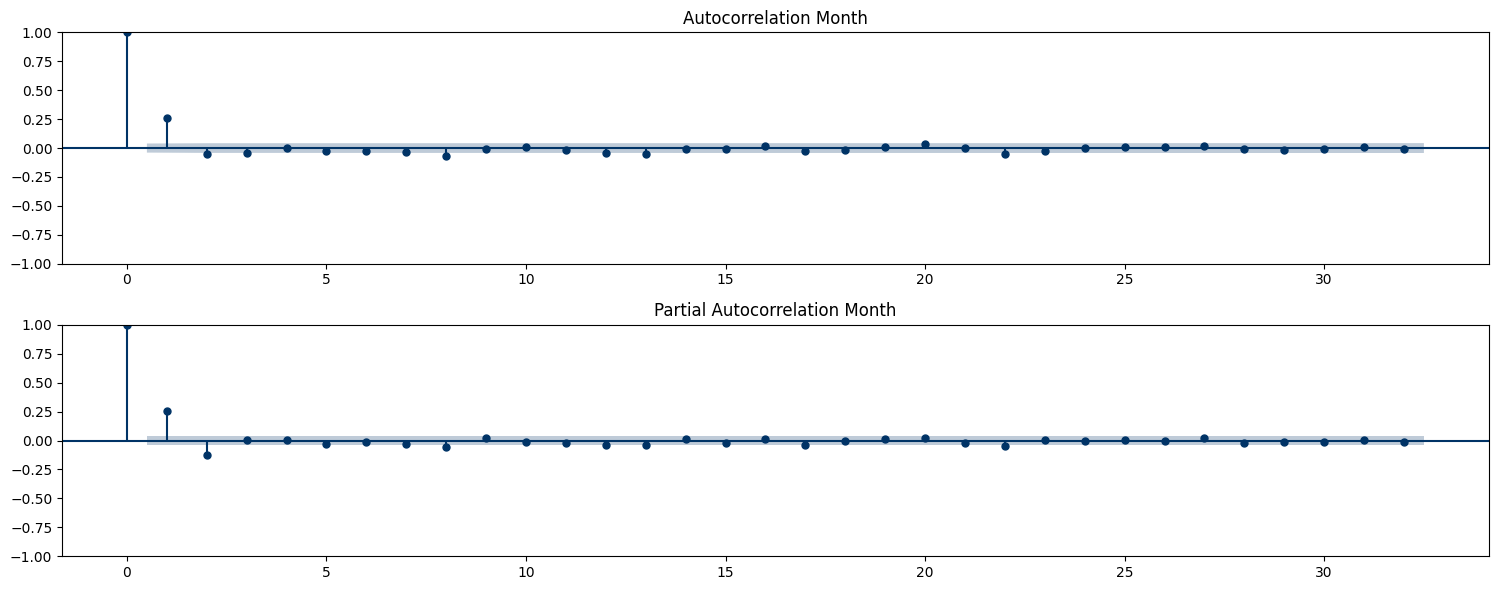

In [172]:
arima_wspd = SARIMAX(weather_df['wspd'], order=(1,0,1))
r_wspd = arima_wspd.fit()
plot_acf_pacf(r_wspd.resid)

The ARIMA(1,0,1) model was not sufficient to capture all the autocorrelation. To capture the remaining autocorrelation, let's try a higher-order model, specifically (2,0,2).

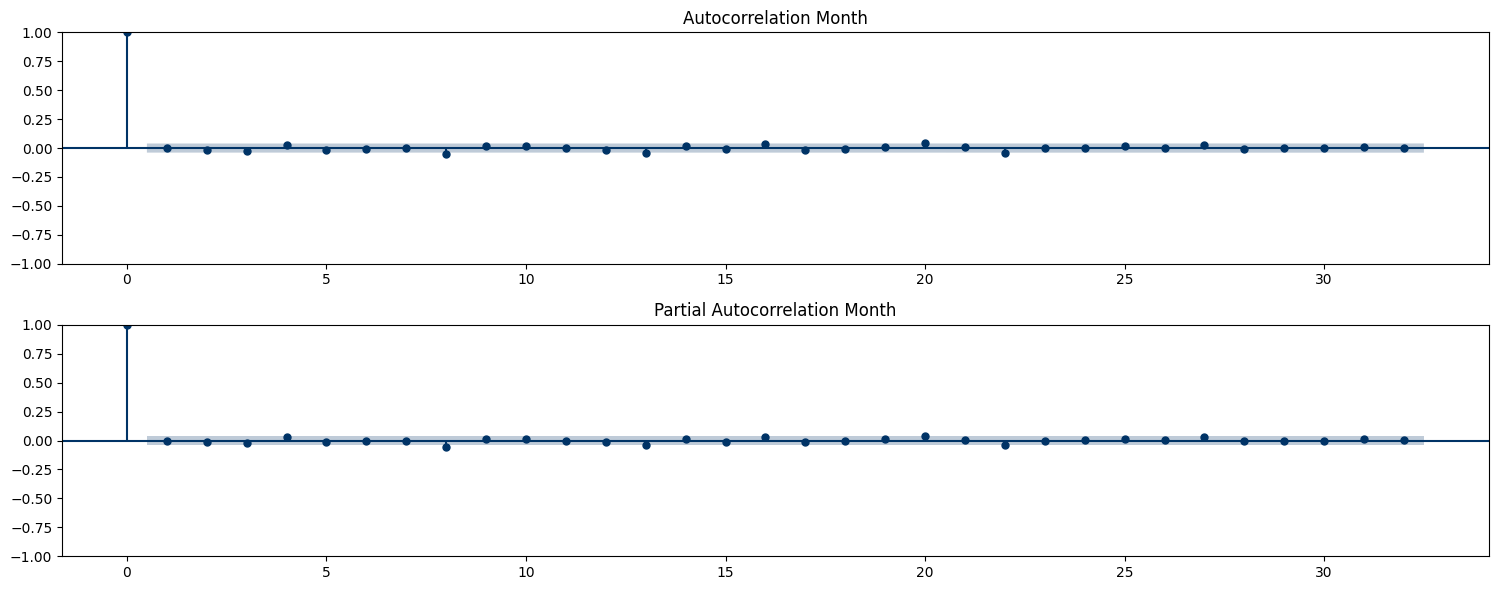

                               SARIMAX Results                                
Dep. Variable:                   wspd   No. Observations:                 2488
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -4441.281
Date:                Mon, 10 Mar 2025   AIC                           8892.563
Time:                        19:31:47   BIC                           8921.659
Sample:                             0   HQIC                          8903.128
                               - 2488                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9767      0.068     14.397      0.000       0.844       1.110
ar.L2          0.0231      0.068      0.341      0.733      -0.110       0.156
ma.L1         -0.6326      0.064     -9.899      0.0

In [173]:
arima_wspd = SARIMAX(weather_df['wspd'], order=(2,0,2))
r_wspd = arima_wspd.fit()
plot_acf_pacf(r_wspd.resid)
print(r_wspd.summary())

The model appears to have captured the autocorrelation. However, upon reviewing the model summary, we observe that the second autoregressive parameter has a p-value greater than 5%, suggesting that it may not be significant for the model. Based on this, we will proceed with an order of (1, 0, 2).

In [174]:
arima_wspd = SARIMAX(weather_df['wspd'], order=(1,0,2))
r_wspd = arima_wspd.fit()

C:\Users\pedro\Documents\GitHub\WeatherForecast\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Although both ARIMA(1,0,2) and ARIMA(2,0,2) models are theoretically valid, the warning regarding non-stationary starting autoregressive parameters in ARIMA(1,0,2) suggests that this model may not fully capture the autocorrelation structure of the data. In contrast, the ARIMA(2,0,2) model fits without any warnings, indicating that it is more stable and effectively captures the data's temporal dependencies. Therefore, based on model stability and better fit, ARIMA(2,0,2) appears to be the more appropriate choice for this series.

In [175]:
arima_wspd = SARIMAX(weather_df['wspd'], order=(2,0,2))
r_wspd = arima_wspd.fit()
weather_df['r_wspd'] = r_wspd.resid

#### pres
Average air pressure

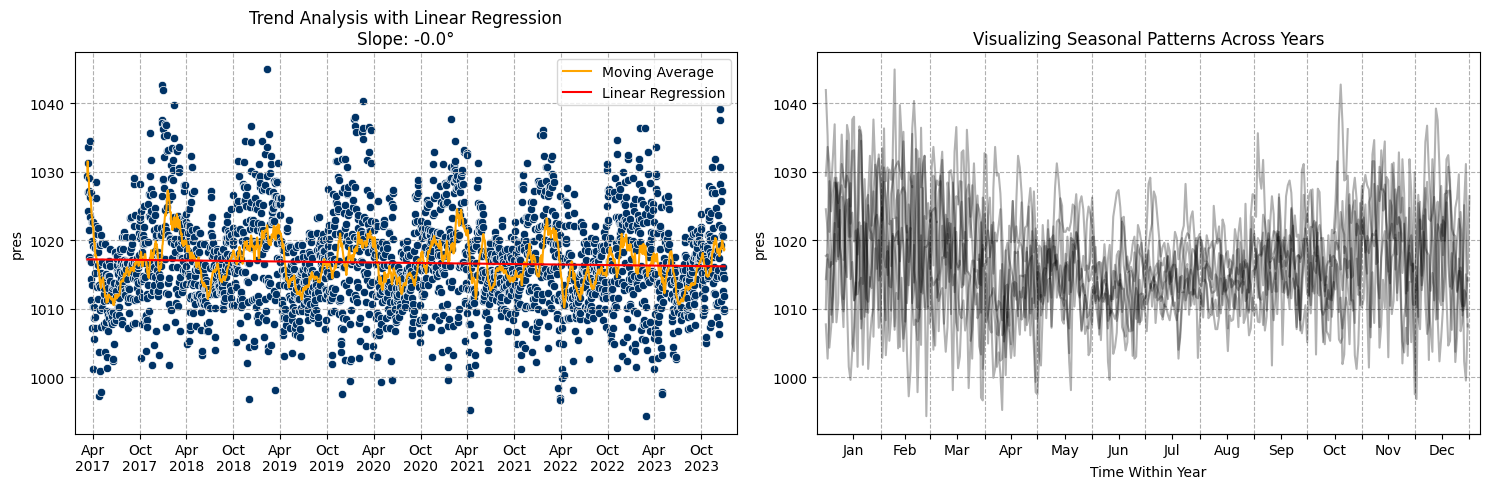

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/pedro/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


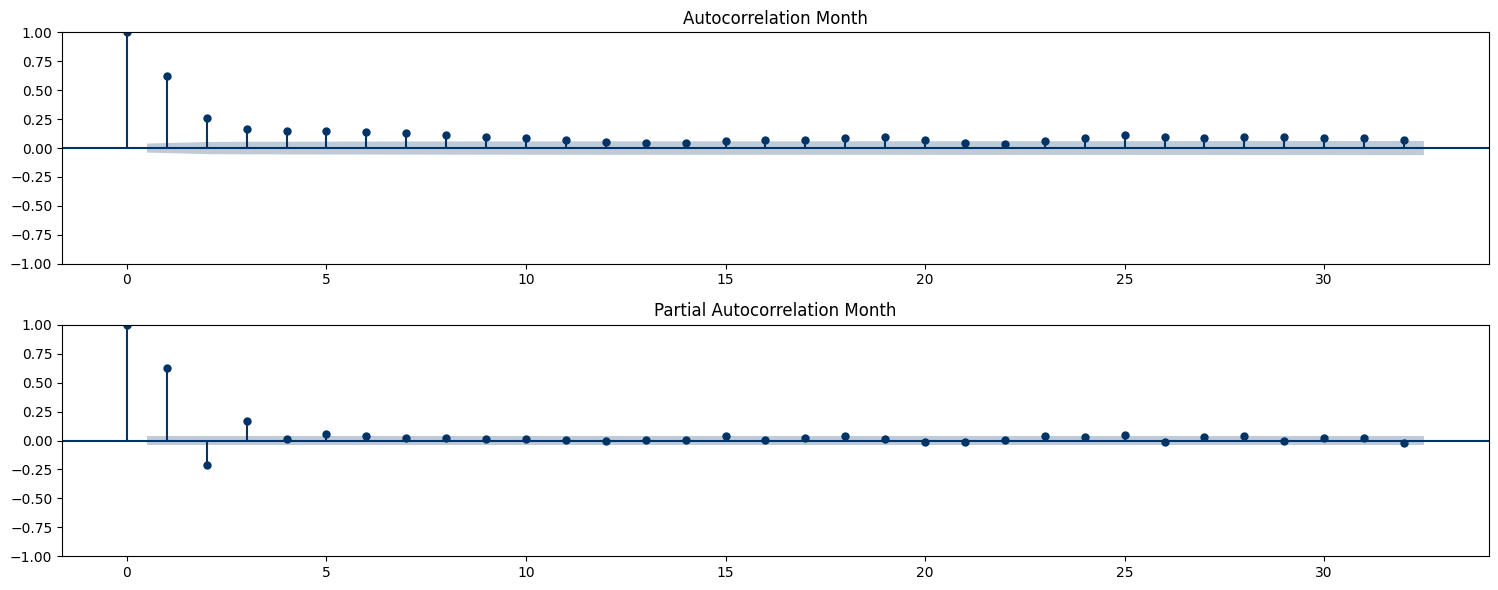

In [176]:
ts_quick_insights(weather_df['pres'], weather_df['time'])   
stationary_tests(weather_df['pres'])
plot_acf_pacf(weather_df['pres'])

Using the year-overlapping plot and the moving average, we can observe a slight seasonal pattern in the series. Additionally, the ACF plot also suggests a non-stationary behavior, despite the p-value from the previous tests. To ensure stationarity in the following analyses, we will apply a seasonal differencing before proceeding.

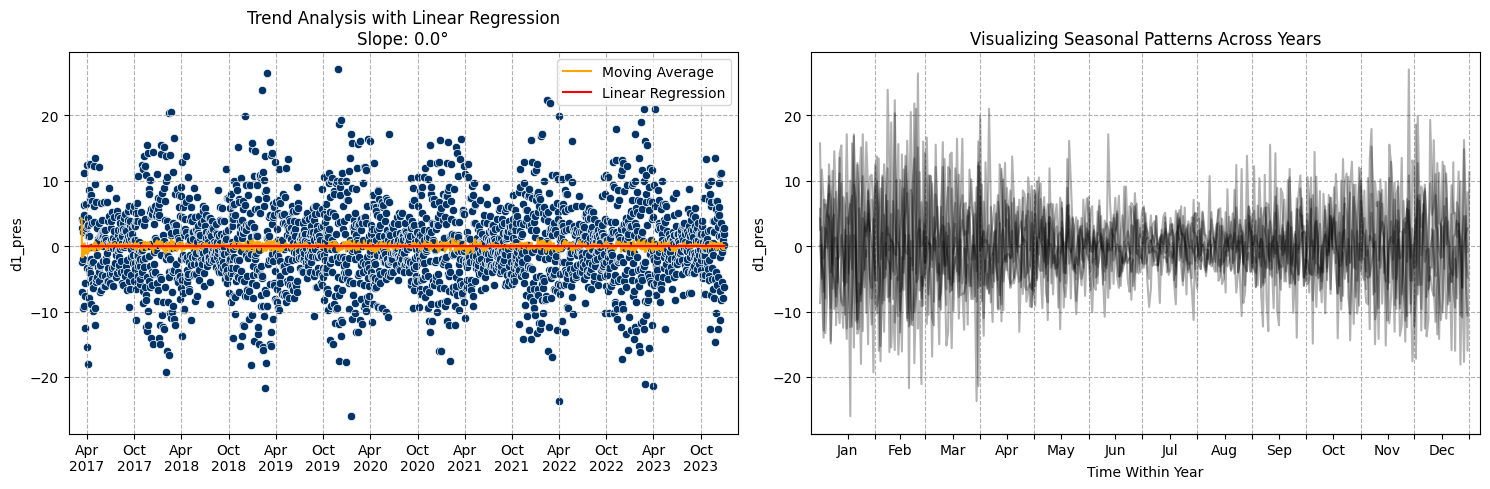

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/pedro/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


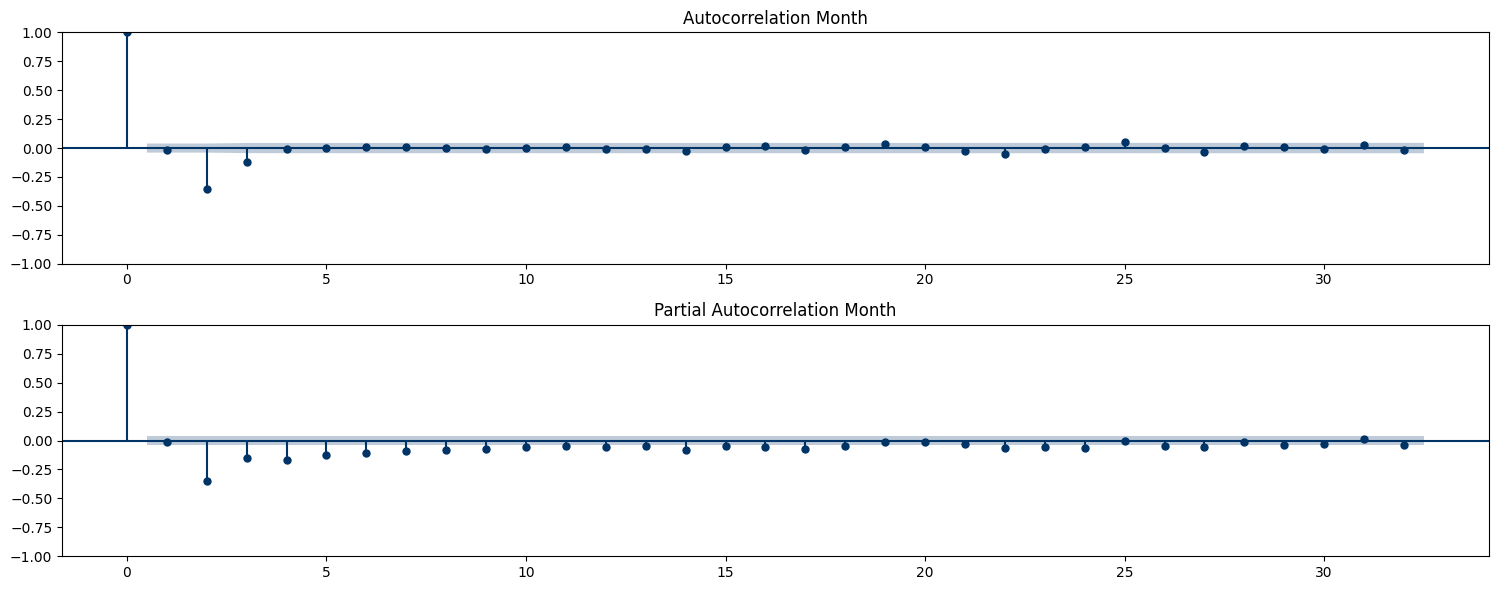

In [177]:
s_pres = weather_df[['pres', 'time']].copy()
s_pres['d1_pres'] = s_pres['pres'].diff()
s_pres.dropna(inplace=True)

ts_quick_insights(s_pres['d1_pres'], s_pres['time'])   
stationary_tests(s_pres['d1_pres'])
plot_acf_pacf(s_pres['d1_pres'])

Based on the ACF and PACF plots, we will define the ARIMA(2,1,2) model as a starting point.

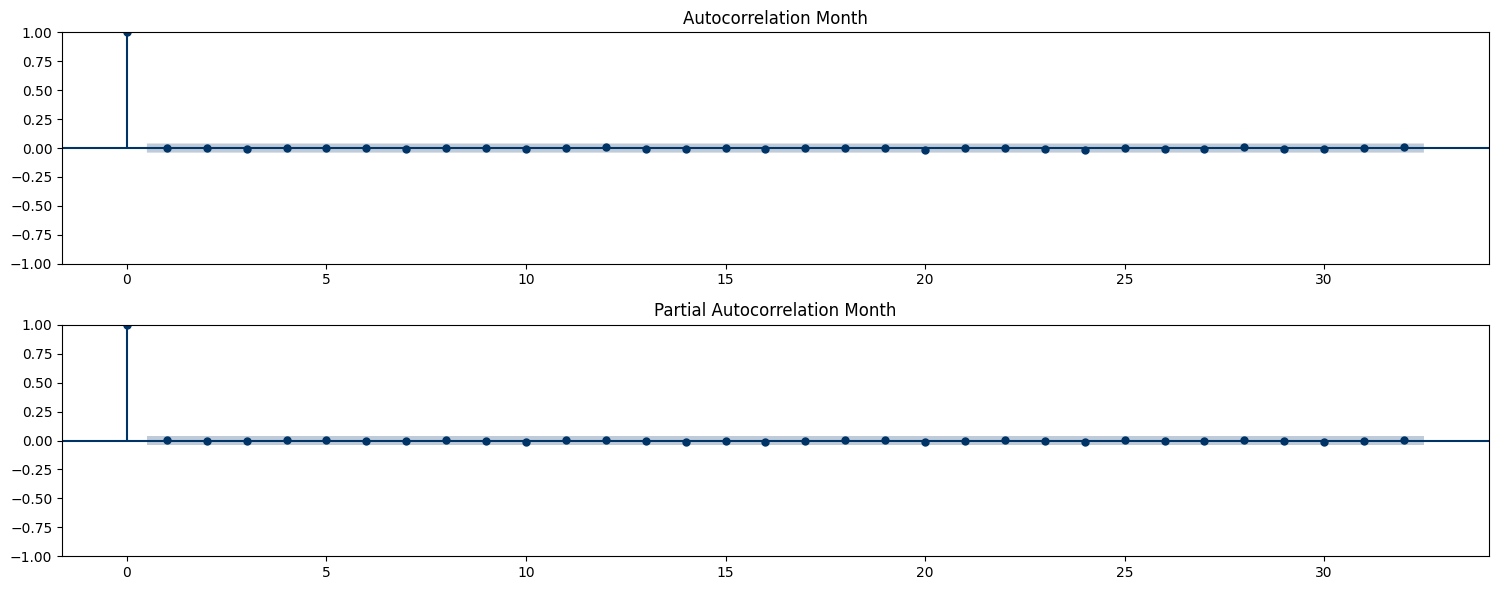

                               SARIMAX Results                                
Dep. Variable:                   pres   No. Observations:                 2488
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7698.890
Date:                Mon, 10 Mar 2025   AIC                          15407.780
Time:                        19:31:51   BIC                          15436.874
Sample:                             0   HQIC                         15418.345
                               - 2488                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3276      0.050      6.497      0.000       0.229       0.426
ar.L2         -0.0215      0.037     -0.576      0.564      -0.095       0.052
ma.L1         -0.5373      0.049    -11.055      0.0

In [178]:
arima_pres = SARIMAX(weather_df['pres'], order=(2,1,2))
r_pres = arima_pres.fit()
plot_acf_pacf(r_pres.resid)
print(r_pres.summary())

The model above successfully removed all autocorrelation from the series. However, when analyzing the model summary, we observe that ar.L2 has a p-value greater than 5%, indicating it is not significant for the model. Therefore, we will test an ARIMA(1,1,2).

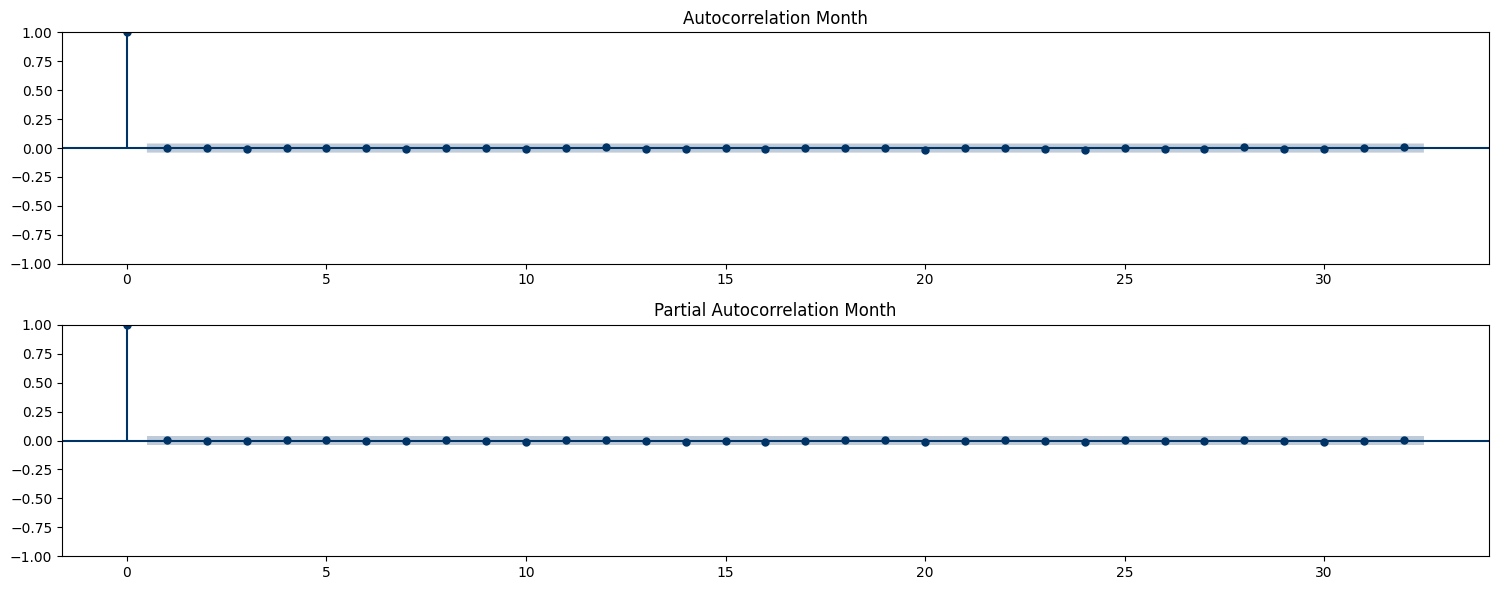

                               SARIMAX Results                                
Dep. Variable:                   pres   No. Observations:                 2488
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -7699.014
Date:                Mon, 10 Mar 2025   AIC                          15406.028
Time:                        19:31:51   BIC                          15429.303
Sample:                             0   HQIC                         15414.480
                               - 2488                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3028      0.027     11.394      0.000       0.251       0.355
ma.L1         -0.5139      0.024    -21.206      0.000      -0.561      -0.466
ma.L2         -0.4407      0.022    -20.102      0.0

In [179]:
arima_pres = SARIMAX(weather_df['pres'], order=(1,1,2))
r_pres = arima_pres.fit()
plot_acf_pacf(r_pres.resid)
print(r_pres.summary())

In [180]:
weather_df['r_pres'] = r_pres.resid

#### tamp
Temperature amplitude

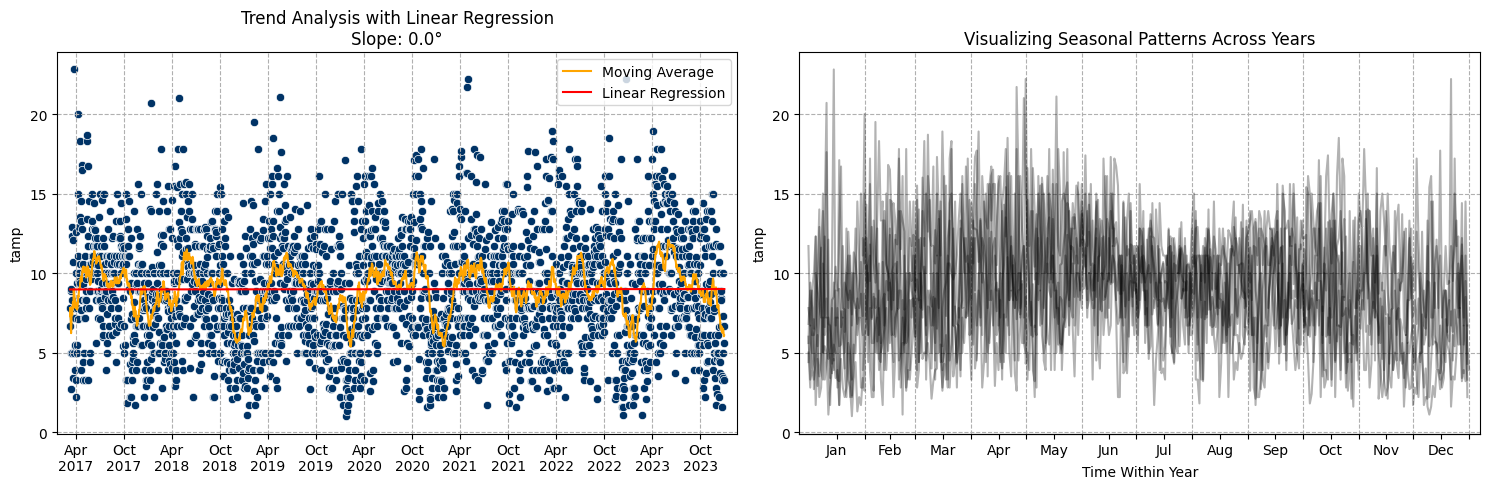

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/pedro/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


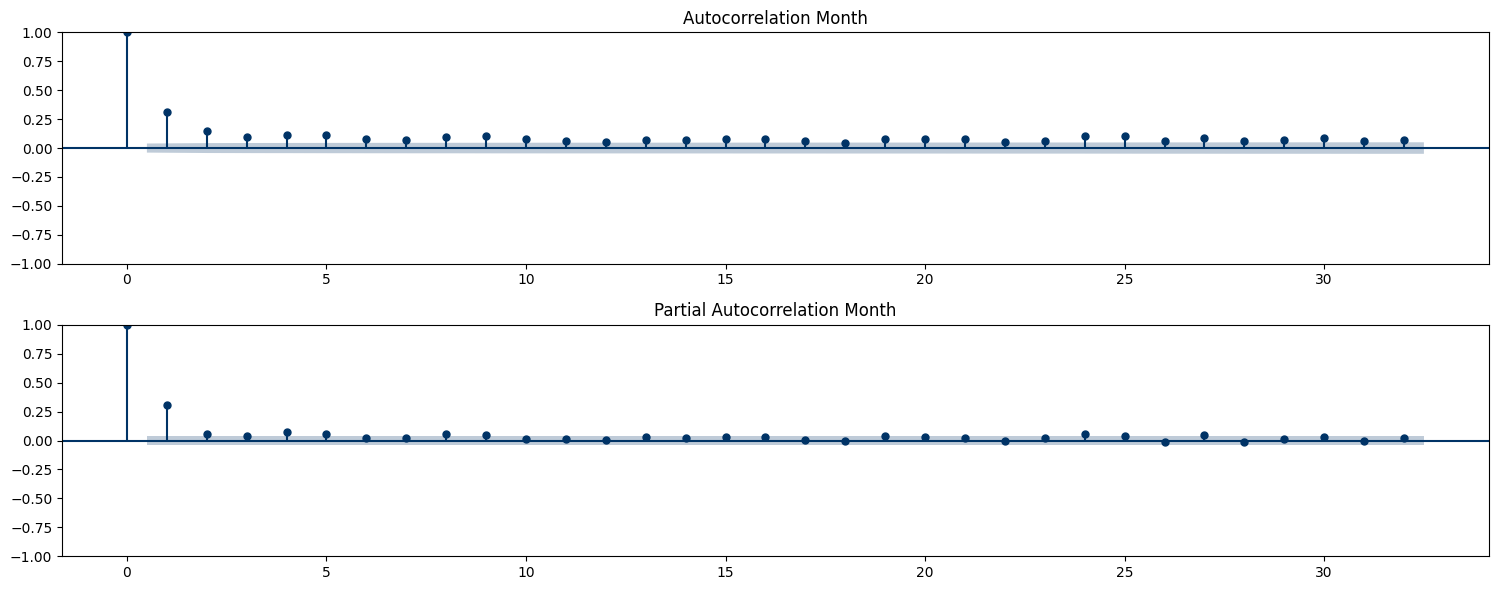

In [181]:
ts_quick_insights(weather_df['tamp'], weather_df['time'])   
stationary_tests(weather_df['tamp'])
plot_acf_pacf(weather_df['tamp'])

Based on the ACF and PACF plots, we will define the ARIMA(1,0,2) model as a starting point.

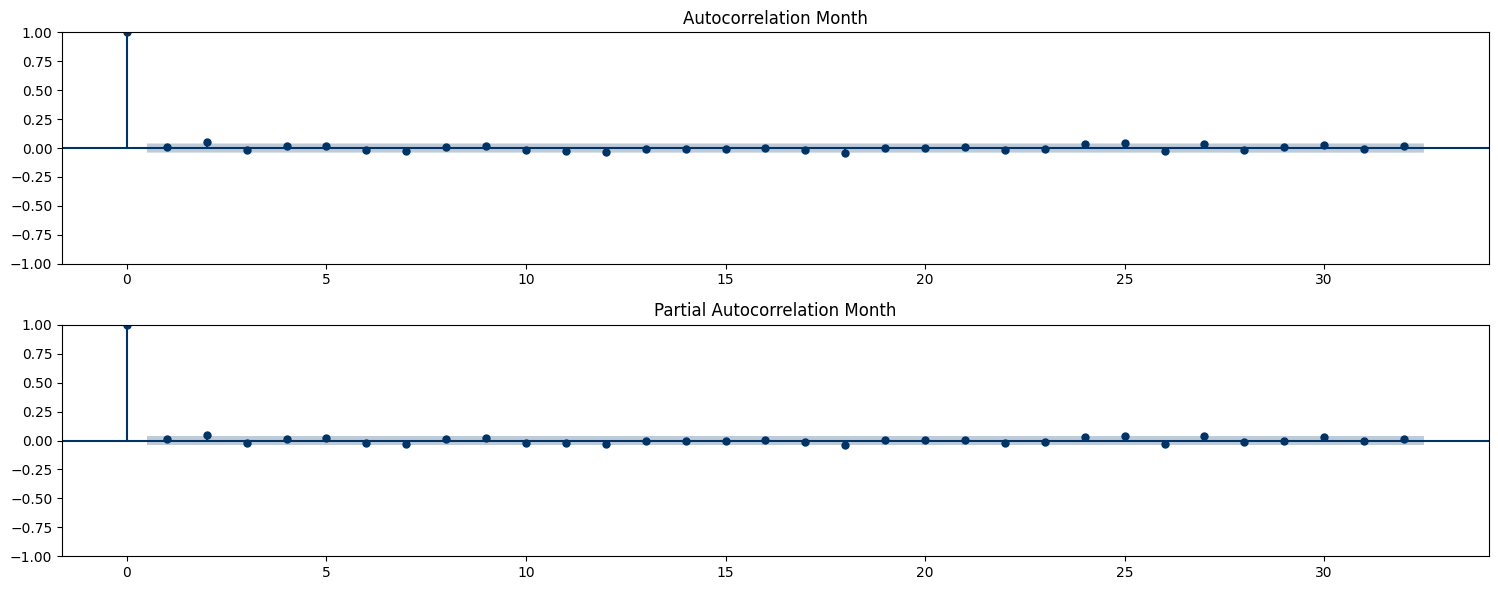

                               SARIMAX Results                                
Dep. Variable:                   tamp   No. Observations:                 2488
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -6579.419
Date:                Mon, 10 Mar 2025   AIC                          13166.837
Time:                        19:31:54   BIC                          13190.114
Sample:                             0   HQIC                         13175.290
                               - 2488                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   2331.041      0.000       0.999       1.001
ma.L1         -0.7340      0.019    -39.340      0.000      -0.771      -0.697
ma.L2         -0.2078      0.018    -11.326      0.0

In [182]:
arima_tamp = SARIMAX(weather_df['tamp'], order=(1,0,2))
r_tamp = arima_tamp.fit()
plot_acf_pacf(r_tamp.resid)
print(r_tamp.summary())

In [183]:
weather_df['r_tamp'] = r_tamp.resid

#### wcardinal
Wind direction. This variable does not fit the temporal aspect explored here due to its qualitative nature. Therefore, we will use it as its own r_wcardinal.

In [184]:
weather_df['wcardinal'].value_counts()

wcardinal
Southwest    476
West         410
Northeast    409
South        357
North        262
Northwest    249
East         183
Southeast    139
Name: count, dtype: int64

In [185]:
weather_df['r_wcardinal'] = weather_df['wcardinal']

### New features

In [186]:
weather_df.columns

Index(['time', 'tavg', 'prcp', 'snow', 'wspd', 'pres', 'tamp', 'wcardinal',
       'tavg_seasonal', 'tavg_seasonal_resid', 'resids', 'r_prcp', 'r_snow',
       'r_wspd', 'r_pres', 'r_tamp', 'r_wcardinal'],
      dtype='object')

In [188]:
'r_prcp', 'r_snow', 'r_wspd', 'r_pres', 'r_tamp', 'r_wcardinal'

('r_prcp', 'r_snow', 'r_wspd', 'r_pres', 'r_tamp', 'r_wcardinal')

#### snow

##  Cross-correlation

## Granger Causality

## Multicollinearity

# Time series modeling

## VAR

## Validation

## Results

# Regression modeling

## Models

### Linear Regression

### Support Vector Regression

### Decision Tree Regressor

### Random Forest Regressor

### XGBoost Regressor

## Results